# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | Kwaku | Owusu | KO 25/10/2024 | 15 Hours | 33% |
| Member 2: | Tunde | Bademosi | TB 25/10/2024 | 15 Hours | 33% |
| Member 3: | Bukola | Sikiru | BS 25/10/2024 | 15 Hours | 33% |
| Member 4: |  |  |  |  |  |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

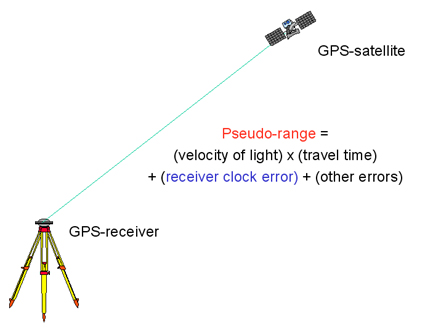

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

Step 0.1: Import necessary libraries

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Step 0.2: Read and parse data files

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/engg680_2024_fall/Lab Assignment 3

/content/drive/MyDrive/Colab Notebooks/engg680_2024_fall/Lab Assignment 3


In [4]:
df_pseudorange = pd.read_excel('pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('satellite_position1.xlsx')

In [25]:
pseudorange = df_pseudorange['P'].to_numpy()
s_pos =df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size
print(n)
print(s_pos)
print(pseudorange)

11
[[  5280791.73836563 -25501460.1192133    4649508.28809917]
 [ -2159656.05205653 -21116024.7920163   15597909.1971221 ]
 [ 10371852.1682927  -21713111.3497771   10558686.998121  ]
 [-16085760.7811889    4285071.21612309  20742042.1246963 ]
 [-14312988.0806279  -22045014.2659254    4671208.3988653 ]
 [ -2435718.18737303  16257205.12951     21099779.5379103 ]
 [ 15912467.1868696   -3462515.31492602  21053628.253335  ]
 [ 16271848.163885     -218766.32031082  21035332.7037679 ]
 [-19247035.5286677   -7259803.67892242  16472981.9071979 ]
 [-15931152.0364578   12077367.2515846   18058076.7648504 ]
 [ -7680014.10843999 -13855462.7231353   21842975.3728112 ]]
[22919740.9614295 20459894.0877988 22400338.4134134 22829140.9126004
 22342014.8171753 25646454.5362932 23814776.2454228 24311399.3171521
 21353640.1406793 24971609.6374347 20638981.0590005]


Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [26]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [27]:
arr_cost= []          # Store cost values during optimization
arr_grad= []          # Hold gradient values
arr_err=[]            # Track of errors during iterations
steps_count=0         # Counts number of iterations

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [28]:
def euclidean_norm(r_pos, s_pos):

    # Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(s_pos - r_pos, axis =1)

    return distance


### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [29]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
def cost_function(r_pos, cdT, s_pos, pseudorange):
  """
  Compute the sum of squared residuals between measured and predicted pseudoranges.

  Parameters:
  r_pos (numpy array):        A 1D array of the receiver's coordinates [x, y, z].
  cdT (float):                The clock offset of the receiver.
  s_pos (numpy array):        A 2D array where each row represents a satellite's coordinates [x, y, z].
  pseudorange (numpy array):  A 1D array of observed pseudoranges (distance measurements).

  Returns:
  float: The sum of squared residuals between the observed and predicted pseudoranges.
  """
  # Calculate the geometric distances using the euclidean_norm function
  predicted_distances = euclidean_norm(r_pos, s_pos)

  # Calculate the predicted pseudoranges by adding the clock offset
  predicted_pseudoranges = predicted_distances + cdT

  # Calculate residuals (differences between observed and predicted pseudoranges)
  residuals = pseudorange - predicted_pseudoranges

  # Compute the sum of squared residuals
  cost = np.sum(residuals ** 2)

  return cost


### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [30]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)
def gradient(r_pos, cdT, s_pos, pseudorange):
    """
    Compute the gradient of the cost function with respect to the receiver's coordinates
    (x_r, y_r, z_r) and clock offset (cdT).

    Parameters:
    r_pos (numpy array):       A 1D array of the receiver's coordinates [x_r, y_r, z_r].
    cdT (float):               The clock offset (cdT) of the receiver.
    s_pos (numpy array):       A 2D array where each row represents a satellite's coordinates [x, y, z].
    pseudorange (numpy array): A 1D array of observed pseudoranges.

    Returns:
    numpy array: A 1D array containing the gradient [∂C/∂x_r, ∂C/∂y_r, ∂C/∂z_r, ∂C/∂cdT].
    """
    # Calculate the predicted distances (geometric distance) from receiver to each satellite
    predicted_distances = euclidean_norm(r_pos, s_pos)

    # Predicted pseudoranges, which include the clock offset
    predicted_pseudoranges = predicted_distances + cdT

    # Calculate residuals
    residuals = pseudorange - predicted_pseudoranges

    # Compute the partial derivatives with respect to each coordinate and clock offset
    # Initialize gradient array
    grad = np.zeros(4)

    # Partial derivatives with respect to x_r, y_r, z_r
    for i in range(3):  # Loop over x, y, z
        grad[i] = -2 * np.sum(residuals * (r_pos[i] - s_pos[:, i]) / predicted_distances)

    # Partial derivative with respect to clock offset (cdT)
    grad[3] = -2 * np.sum(residuals)

    return grad


### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [35]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, s_pos, learning_rate=0.1, max_iters=10000, tolerance=1e-6):

    global steps_count
    arr_cost = []
    arr_grad = []
    arr_err = []


    #initalize the estimates as zeros
    X = np.array([0.0,0.0,0.0,0.0])

    for iteration in range(max_iters):
        r_pos = X[:3]
        cdT = X[3]

        # compute the cost in the current step
        # (1 mark)
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)

        # compute the gradients in the current step
        # (1 mark)
        grad = gradient(r_pos, cdT, s_pos, pseudorange)

        # Clip gradients to avoid excessively large updates
        grad = np.clip(grad, -1e10, 1e10)


        # update estimates
        # (1 mark)
        X_new = X - learning_rate * grad

        # compute the new cost
        # (1 mark)
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

        # break the loop if converge
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged !")
            steps_count=iteration
            break

        # update the parameters for the next iteration
        X = X_new

        #collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3]-GroundTruth)

    return X

In [36]:
def cost_function(r_pos, cdT, s_pos, observed_pseudoranges):
    predicted_distances = np.linalg.norm(s_pos - r_pos, axis=1) + 1e-10  # Add small epsilon
    predicted_pseudoranges = predicted_distances + cdT
    residuals = observed_pseudoranges - predicted_pseudoranges
    cost = np.sum(residuals ** 2)
    return np.nan_to_num(cost)  # Replace NaN/Inf in cost

def compute_gradient(r_pos, cdT, s_pos, observed_pseudoranges):
    predicted_distances = np.linalg.norm(s_pos - r_pos, axis=1) + 1e-10  # Add small epsilon
    predicted_pseudoranges = predicted_distances + cdT
    residuals = observed_pseudoranges - predicted_pseudoranges
    grad = np.zeros(4)

    for i in range(3):
        grad[i] = -2 * np.sum(residuals * (r_pos[i] - s_pos[:, i]) / predicted_distances)

    grad[3] = -2 * np.sum(residuals)
    return np.nan_to_num(grad)  # Replace NaN/Inf in gradient


### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [37]:
# Call the gradient_descent function to optimize
optimized_params = gradient_descent(pseudorange, s_pos, learning_rate=0.0001)

# Calculate final position errors (GroundTruth defined previously)
final_position_error = optimized_params[:3] - GroundTruth

# print the mentioned metrics
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params)
print("Final Position Errors of Receiver:", final_position_error)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", arr_cost[-1])          # Last cost in the array
print("Final Gradient Values:", arr_grad[-1])     # Last gradient in the array

Optimized Parameters (x_r, y_r, z_r, cdT): [-1469858.76312146 -2838017.8095697   2483232.22288273 -1493273.80333624]
Final Position Errors of Receiver: [  163630.61655579   813609.37293393 -2469249.39666645]
Number of Steps Taken for Convergence: 556
Final Cost Value: 1.7175349630804509e+308
Final Gradient Values: [-1.48906907e+154  4.44525106e+153 -8.55316369e+154 -8.69318919e+154]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

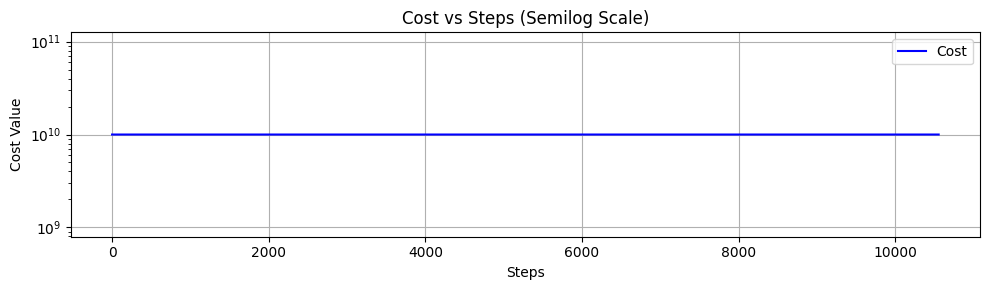

In [49]:
# Assuming arr_cost is a list of costs at each step
arr_cost = np.array(arr_cost)

# Filter out NaN and Inf values
arr_cost = np.nan_to_num(arr_cost, nan=np.inf, posinf=np.inf)

# Clip large cost values to prevent overflow in plotting
max_cost_value = 1e10  # Define a suitable max value based on your data
arr_cost = np.clip(arr_cost, 0, max_cost_value)

# Create steps for the x-axis
steps = np.arange(len(arr_cost))

# Initialize figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

# Plot cost vs steps with semilog scale
ax.semilogy(steps, arr_cost, label='Cost', color='blue')

# Label the axes
ax.set_xlabel("Steps")
ax.set_ylabel("Cost Value")
ax.set_title("Cost vs Steps (Semilog Scale)")

# Add grid and legend
ax.grid(True)
ax.legend()

# Optimize layout
fig.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Comment on the pattern
# ...

### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

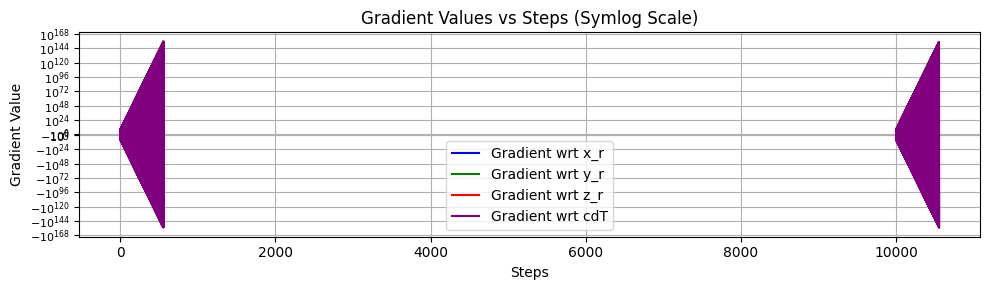

In [40]:
# Initialize figure and axes
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
# Convert arr_grad to a numpy array for easier plotting
arr_grad = np.array(arr_grad)

# Extract gradient components and steps
grad_x, grad_y, grad_z, grad_cdT = arr_grad[:, 0], arr_grad[:, 1], arr_grad[:, 2], arr_grad[:, 3]
steps = np.arange(len(arr_grad))

# Plot each gradient component
ax.plot(steps, grad_x, label='Gradient wrt x_r', color='b')
ax.plot(steps, grad_y, label='Gradient wrt y_r', color='g')
ax.plot(steps, grad_z, label='Gradient wrt z_r', color='r')
ax.plot(steps, grad_cdT, label='Gradient wrt cdT', color='purple')

# Set y-axis to symlog scale
ax.set_yscale('symlog')

# Customize y-axis tick labels
ax.tick_params(axis='y', labelsize=8)

# Add labels, title, legend, and grid
ax.set_xlabel("Steps")
ax.set_ylabel("Gradient Value")
ax.set_title("Gradient Values vs Steps (Symlog Scale)")
ax.legend()
ax.grid(True)  # Add gridlines

# Adjust layout for better spacing
fig.tight_layout()

# Show the plot
plt.show()



In [ ]:
# Comment on the pattern
# ...

### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

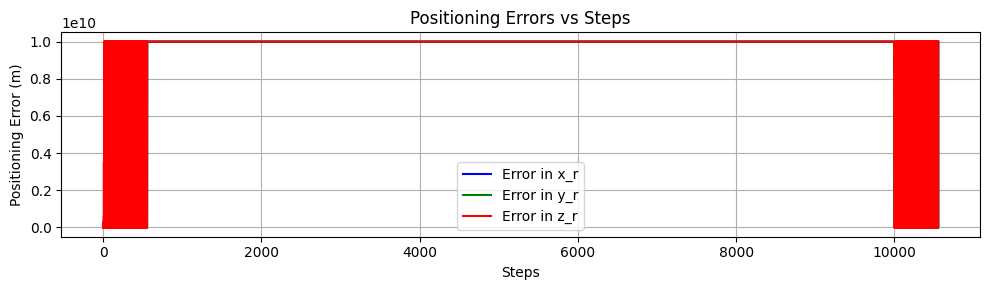

In [51]:
# Convert arr_err to a numpy array for easier plotting
arr_err = np.array(arr_err)

# Filter out NaN and Inf values
arr_err = np.nan_to_num(arr_err, nan=np.inf, posinf=np.inf)

# Clip large cost values to prevent overflow in plotting
max_err_value = 1e10  # Define a suitable max value based on your data
arr_err = np.clip(arr_err, 0, max_err_value)


# Create an array for steps
steps = np.arange(len(arr_err))

# Initialize figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

# Plot positioning errors vs steps
# Extracting the x, y, and z positioning errors
ax.plot(steps, arr_err[:, 0], label='Error in x_r', color='blue')
ax.plot(steps, arr_err[:, 1], label='Error in y_r', color='green')
ax.plot(steps, arr_err[:, 2], label='Error in z_r', color='red')

# Label the axes
ax.set_xlabel("Steps")
ax.set_ylabel("Positioning Error (m)")
ax.set_title("Positioning Errors vs Steps")

# Add grid, legend
ax.grid(True)
ax.legend()

# Optimize layout
fig.tight_layout()

# Show the plot
plt.show()



In [ ]:
# Comment on the pattern
# ...

# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [ ]:
#set learning rate to 0.01
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_2 = #...

# print the metrics
# ...

In [ ]:
#set learning rate to 0.001
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_3 = #...

# print the metrics
# ...

## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)



ANSWER HERE

---
---

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# TO DO: data (as pandas dataframes) (1 mark)

# TO DO: display sizes of X and y (1 mark)


### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

In [ ]:
# TO DO: Check the class distribution of y (2 mark)


# Display exact values for each bin in the histogram

plt.show()

### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [ ]:
# TO DO: Create a smaller dataset with 3% of the data


# TO DO: display sizes of X_small and y_small (2 mark)


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [ ]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)

# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information



### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [ ]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set


In [ ]:
import seaborn as sns

# TO DO: Calculate confusion matrix (2 marks) : conf_mat

# Below code prints confusion matrix using a heatmap
sns.heatmap(conf_mat, xticklabels=['not phishing', 'phishing'],  yticklabels=['not phishing', 'phishing'], square=True, annot=True, cbar=False, fmt='d')
plt.xlabel('predicted value')
plt.ylabel('true value')

In [ ]:
# TO DO: Print classification report (2 marks)


ANSWER ** **bold text**HERE**

### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE

---1. Dataset is , and it ..  affect model performance
---2. The model overfit for..